<span style="color:blue"> This notebook employs the same concepts as the Fluid_Prediction_1 notebook, with the exception of testing with a limited data set and a reduced number of epochs. Additionally, in this instance, it was used classic  loss function and metric, the error was calculated across the entire pixel range ans tanh as activation function.  </span>


In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
from pathlib                            import Path
from tensorflow.keras.callbacks         import LearningRateScheduler
from tensorflow.keras.layers            import Lambda
import sys
import os
import numpy                            as np
import math
import random, time
import pandas                           as pd

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt
from decimal                        import Decimal


2024-12-03 01:40:51.611677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 01:40:51.619209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 01:40:51.627624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 01:40:51.630086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 01:40:51.636661: I tensorflow/core/platform/cpu_feature_guar

### <span style="color:blue">I. Load directories</span>

In [2]:
# Files path
directory_one = os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES-VER-4")
directory_two = os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")

# Add directory to sys.path
sys.path.append(directory_one)
sys.path.append(directory_two)

# import scripts
import param 

# This script is about preprocessing the images, binary the geometry and fhe flow patterns in grayscales
from preprocessing         import *    

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# Set the number of cores
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

### <span style="color:blue">II. Processing data</span>

In [3]:
#Load the main directory, there are paths of the flow patterns and the geometry 
paths=param.list_paths 
for i,j in enumerate(paths):
    print(f'{i} => {j}')

# Defining amount of train,valid,test images
n_train=0.8;    n_valid=0.1;    n_test=0.1

# Defining a sample i.e. 500 images
n_sample=90   #  500                                       


0 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry
1 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude
2 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Pression
3 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U001
4 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U002


#### <span style="color:blue">II.1 Split data: train, valid and test sets</span>

In [4]:
# Geometry
geo_train,geo_valid,geo_tests=split_data(paths[0],n_sample,n_train,n_valid,n_test)
geo_array_train=arrays_img_processed(geo_train)
geo_array_valid=arrays_img_processed(geo_valid)
geo_array_tests=arrays_img_processed(geo_tests)

# Magnitude
specific_tarjet=paths[1]

mag_train,mag_valid,mag_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
mag_array_train=arrays_img_processed(mag_train,False)
mag_array_valid=arrays_img_processed(mag_valid,False)
mag_array_tests=arrays_img_processed(mag_tests,False)

print(f'Training data for geometry: {geo_array_train.shape}')
print(f'Training data for magnitude: {mag_array_train.shape}')
print()
print(f'Valid data for geometry: {geo_array_valid.shape}')
print(f'Valid data for magnitude: {mag_array_valid.shape}')
print()
print(f'Test data for geometry: {geo_array_tests.shape}')
print(f'Test data for magnitude: {mag_array_tests.shape}')


 ######  	 Loaded  90  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry 	 #####


 ######  	 Loaded  90  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude 	 #####

Training data for geometry: (71, 128, 256, 1)
Training data for magnitude: (71, 128, 256, 1)

Valid data for geometry: (8, 128, 256, 1)
Valid data for magnitude: (8, 128, 256, 1)

Test data for geometry: (8, 128, 256, 1)
Test data for magnitude: (8, 128, 256, 1)


### <span style="color:blue">III. Setup hiperparameters</span>


In [5]:
# Dimentions of input data
h=128
w=256
ch=1 # Channel 
num_epochs=80
batch_size=50
patience=40   # How long to wait after last time validation loss improved  
LR=0.001                                 
DECAY_RATE=0.015

# Constans for loss and metric functions
eps = 1e-4
C = 1e-2
   

#### <span style="color:blue">III.1. Learning rate schedule: Learning rate variable</span>



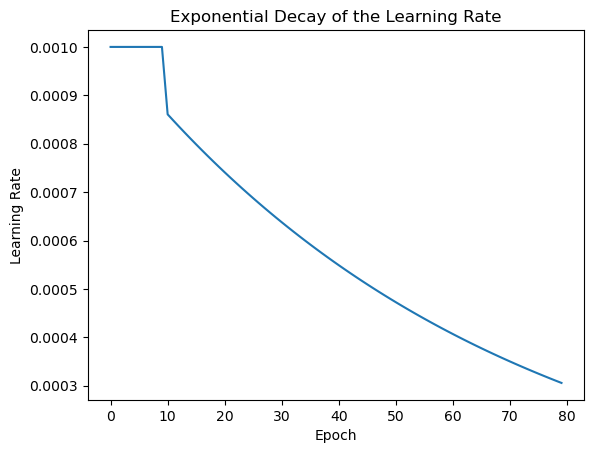

In [6]:
def exponential_decay(epoch,epochs=num_epochs,lr_ini=LR,decay_rate=DECAY_RATE):
  
    if epoch < epochs/(2**3): 
        return lr_ini
    else:
        return  lr_ini * np.exp(-decay_rate*epoch)

lr_scheduler = LearningRateScheduler(lambda epoch: exponential_decay(epoch))

epochs = np.arange(num_epochs)
learning_rates = [exponential_decay(epoch,num_epochs) for epoch in epochs]

plt.plot(epochs, learning_rates, label="Learning Rate")
plt.title("Exponential Decay of the Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(False)
plt.show()

#### <span style="color:blue">III.2. Loss function and metric </span>

In [7]:
def mseplus(u_true,u_pred):
    error = tf.square(u_true - u_pred)  # (u_true - u_pred)^2
    mse = tf.reduce_mean(error) 
    return mse

In [8]:
'''
def mseplus(u_true,u_pred):
    
    error=u_true-u_pred
    mse=tf.reduce_sum(tf.square(error), axis=-1)                   # ||u_pred - u_true||_2^2
   
    norm_error=tf.sqrt(mse)                                        # ||u_pred - u_true||_2
                                 
    norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred), axis=-1)) # ||u_pred||_2
    #norm_u_true=tf.sqrt(tf.reduce_sum(tf.square(u_true), axis=-1))
    

    #E = mse + C* norm_error/(norm_u_true + eps)
    E = mse + C* norm_error/(norm_u_pred + eps)
    E = tf.boolean_mask(E, E>0)
    mse_plus=tf.reduce_mean(E)
    
    #Ip=tf.shape(mse_plus)
    #Ip = tf.cast(Ip, tf.float32)
    #mse_plus=tf.reduce_sum(mse_plus)/Ip
    
    return mse_plus
'''

'\ndef mseplus(u_true,u_pred):\n    \n    error=u_true-u_pred\n    mse=tf.reduce_sum(tf.square(error), axis=-1)                   # ||u_pred - u_true||_2^2\n   \n    norm_error=tf.sqrt(mse)                                        # ||u_pred - u_true||_2\n                                 \n    norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred), axis=-1)) # ||u_pred||_2\n    #norm_u_true=tf.sqrt(tf.reduce_sum(tf.square(u_true), axis=-1))\n    \n\n    #E = mse + C* norm_error/(norm_u_true + eps)\n    E = mse + C* norm_error/(norm_u_pred + eps)\n    E = tf.boolean_mask(E, E>0)\n    mse_plus=tf.reduce_mean(E)\n    \n    #Ip=tf.shape(mse_plus)\n    #Ip = tf.cast(Ip, tf.float32)\n    #mse_plus=tf.reduce_sum(mse_plus)/Ip\n    \n    return mse_plus\n'

In [9]:
def maeplus(u_true,u_pred):
    error = tf.abs(u_true - u_pred)  
    mae = tf.reduce_mean(error) 
    return mae

In [10]:
'''
def maeplus(u_true,u_pred):

    error=u_true-u_pred
    mae=tf.reduce_sum(tf.abs(error), axis=-1)

    norm_error=tf.sqrt(tf.reduce_sum(tf.square(error), axis=-1))
    norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred),  axis=-1 ))
    #norm_u_true=tf.sqrt(tf.reduce_sum(tf.square(u_true),  axis=-1 ))
    
    #E = mae + C* norm_error/(norm_u_true + eps)
    E = mae + C* norm_error/(norm_u_pred + eps)
    condition = E > 0
    mae_plus = tf.boolean_mask(E, condition)
    mse_plus=tf.reduce_mean(mae_plus)
    
    #Ip=tf.shape(mae_plus)
    #Ip = tf.cast(Ip, tf.float32)
    #mae_plus=tf.reduce_sum(mae_plus)/Ip
    
    return mae_plus

'''    

'\ndef maeplus(u_true,u_pred):\n\n    error=u_true-u_pred\n    mae=tf.reduce_sum(tf.abs(error), axis=-1)\n\n    norm_error=tf.sqrt(tf.reduce_sum(tf.square(error), axis=-1))\n    norm_u_pred=tf.sqrt(tf.reduce_sum(tf.square(u_pred),  axis=-1 ))\n    #norm_u_true=tf.sqrt(tf.reduce_sum(tf.square(u_true),  axis=-1 ))\n    \n    #E = mae + C* norm_error/(norm_u_true + eps)\n    E = mae + C* norm_error/(norm_u_pred + eps)\n    condition = E > 0\n    mae_plus = tf.boolean_mask(E, condition)\n    mse_plus=tf.reduce_mean(mae_plus)\n    \n    #Ip=tf.shape(mae_plus)\n    #Ip = tf.cast(Ip, tf.float32)\n    #mae_plus=tf.reduce_sum(mae_plus)/Ip\n    \n    return mae_plus\n\n'

### <span style="color:blue">IV. U-Net Architecture and Model</span>

In [11]:
#func_activation='relu'
func_activation='tanh'
kernel_size=3
num_classes=1

In [12]:
def u_net():
        input_shape=(h,w,ch)
        inputs = layers.Input(shape=input_shape)
    
         # ************  Encoder block  *************
        conv1 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
 
        conv3 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
       
        conv4 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(conv4)
        conv4 = BatchNormalization()(conv4)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = layers.Conv2D(1024, kernel_size, activation=func_activation, padding='same')(pool4)
        conv5 = layers.Conv2D(1024, kernel_size, activation=func_activation, padding='same')(conv5)
       
        # ************  Decoder block ****************
    
        up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(conv5)
        up6 = layers.concatenate([up6, conv4])
        conv6 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(up6)
        conv6 = layers.Conv2D(512, kernel_size, activation=func_activation, padding='same')(conv6)

        up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv6)
        up7 = layers.concatenate([up7, conv3])
        conv7 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(up7)
        conv7 = layers.Conv2D(256, kernel_size, activation=func_activation, padding='same')(conv7)

        up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv7)
        up8 = layers.concatenate([up8, conv2])
        conv8 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(up8)
        conv8 = layers.Conv2D(128, kernel_size, activation=func_activation, padding='same')(conv8)

        up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv8)
        up9 = layers.concatenate([up9, conv1])
        conv9 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(up9)
        conv9 = layers.Conv2D(64, kernel_size, activation=func_activation, padding='same')(conv9)

        outputs = layers.Conv2D(num_classes, (1,1), activation=func_activation,padding="same")(conv9)
    
        model = models.Model(inputs=[inputs], outputs=[outputs])
    
        model.summary()
        return model

In [13]:
def execute_model(model):
    
        # **********************************************  Compile  and Fit model   *******************************************
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/Best_weights.weights.h5",save_weights_only=True)
            
        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
        
        model.compile(optimizer=optimizer, loss=mseplus, metrics=[maeplus])

        save_callback = SaveOutputCallback('output_training.txt')
          
        history= model.fit(geo_array_train,mag_array_train,
                           batch_size=batch_size,validation_data=(geo_array_valid,mag_array_valid),
                           epochs=num_epochs,
                           callbacks=[early_stopping,checkpoint_cb,save_callback,lr_scheduler])
                           #callbacks=[early_stopping,checkpoint_cb,lr_scheduler])
        
        callbacks = [tf.keras.callbacks.ModelCheckpoint("/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/Unet.keras",save_best_only=True)]
        model.save('/home/guiomar/Desktop/CODES/DLCODES-VER-4/result_saved/Completed_Model.h5')
        return history


In [14]:
M=u_net()

I0000 00:00:1733208053.230378  108004 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 01:40:53.249768: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,038,273 (118.40 MB)

 Trainable params: 31,034,433 (118.39 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [15]:
model=execute_model(M)

Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - loss: 0.4578 - maeplus: 0.5814 - val_loss: 0.2951 - val_maeplus: 0.4608 - learning_rate: 0.0010
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 0.3031 - maeplus: 0.4355 - val_loss: 0.1022 - val_maeplus: 0.2828 - learning_rate: 0.0010
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 0.1947 - maeplus: 0.3302 - val_loss: 0.1998 - val_maeplus: 0.3509 - learning_rate: 0.0010
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - loss: 0.1679 - maeplus: 0.3195 - val_loss: 0.2716 - val_maeplus: 0.4369 - learning_rate: 0.0010
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 0.1679 - maeplus: 0.3252 - val_loss: 0.3042 - val_maeplus: 0.4721 - learning_rate: 0.0010
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 0.1610 - maeplus: 0.3206 - val_loss: 0.3158 - val_maeplus: 0.4839 - learning_rate: 0.0010
Epoch 7/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 0.1571 - maeplus: 0.3165 - val_loss: 0.3124 - val_maeplus: 0.4800 - 

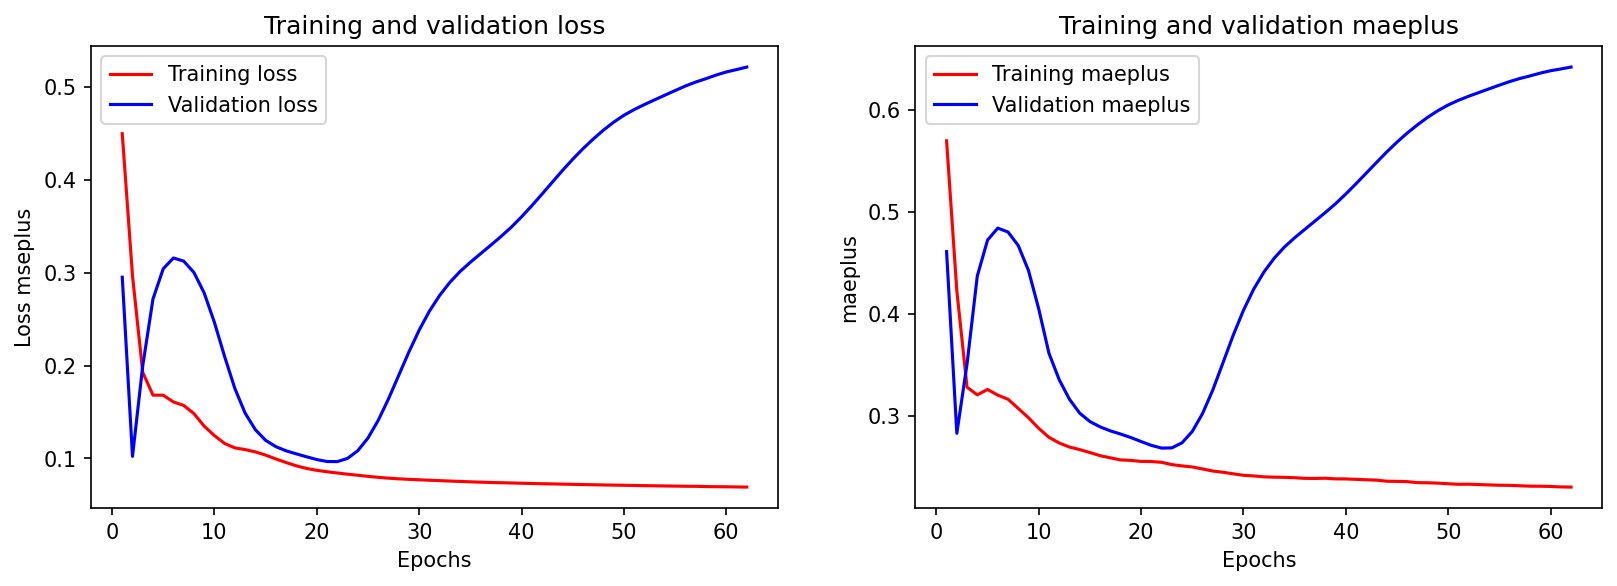

In [16]:
show_results(model)

In [17]:
df = pd.read_csv("output_training.txt")  
print('\n Dataframe')
print(df.head(10))
print('\n Statistics')
stats=df[['Mseplus', 'Maeplus','Val_Mseplus','Val_Maeplus']].describe()

print(stats)



 Dataframe
   Epoch   Mseplus   Maeplus  Val_Mseplus  Val_Maeplus
0      1  0.449633  0.569399     0.295133     0.460799
1      2  0.296667  0.422534     0.102214     0.282795
2      3  0.192660  0.327908     0.199790     0.350922
3      4  0.168125  0.320508     0.271624     0.436882
4      5  0.168110  0.325765     0.304186     0.472077
5      6  0.160797  0.320218     0.315827     0.483851
6      7  0.157081  0.316203     0.312428     0.480034
7      8  0.148293  0.307217     0.300210     0.466798
8      9  0.134786  0.298071     0.278185     0.442355
9     10  0.124581  0.287693     0.246519     0.404742

 Statistics
         Mseplus    Maeplus  Val_Mseplus  Val_Maeplus
count  62.000000  62.000000    62.000000    62.000000
mean    0.098815   0.260454     0.303282     0.458258
std     0.059992   0.052515     0.144521     0.129257
min     0.069160   0.230129     0.096590     0.268344
25%     0.071728   0.234728     0.166820     0.327706
50%     0.076317   0.240622     0.302746     0

### <span style="color:blue">V. Evaluate</span>

In [18]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = M.evaluate(geo_array_tests, mag_array_tests)
print("test loss, test metric:",results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step - loss: 0.0981 - maeplus: 0.2707
test loss, test metric: [0.09813755005598068, 0.270664244890213]


### <span style="color:blue">VI. Predictions</span>

In [19]:
u_predictions = M.predict(geo_array_tests) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


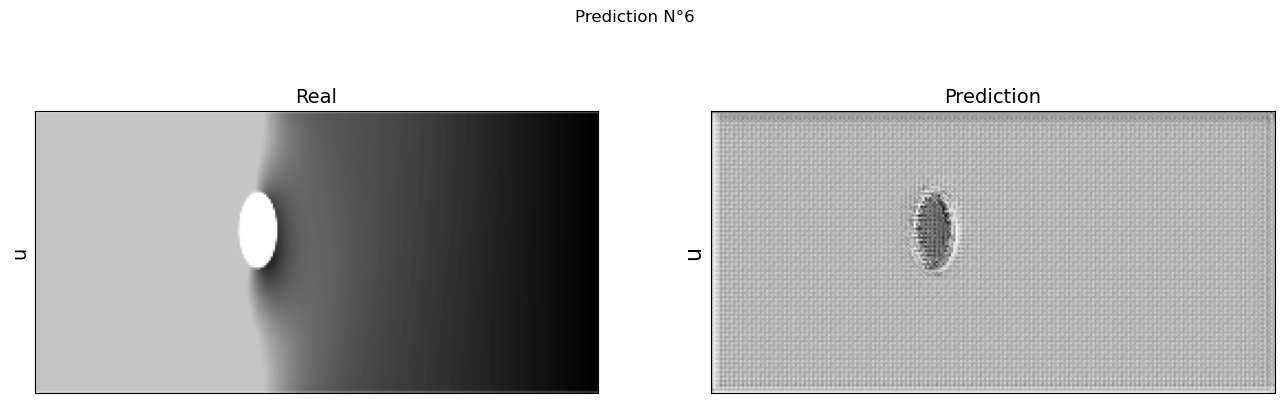

In [20]:

NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

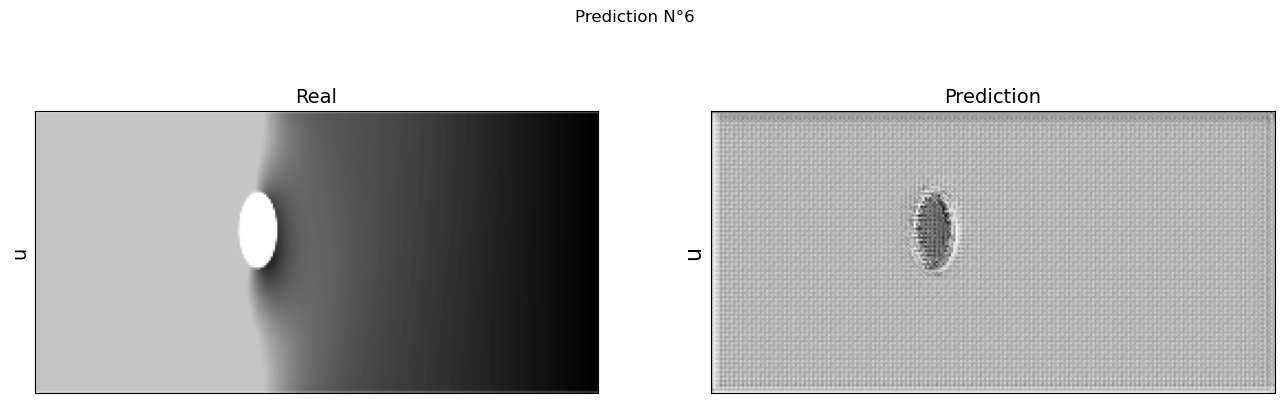

In [21]:

NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

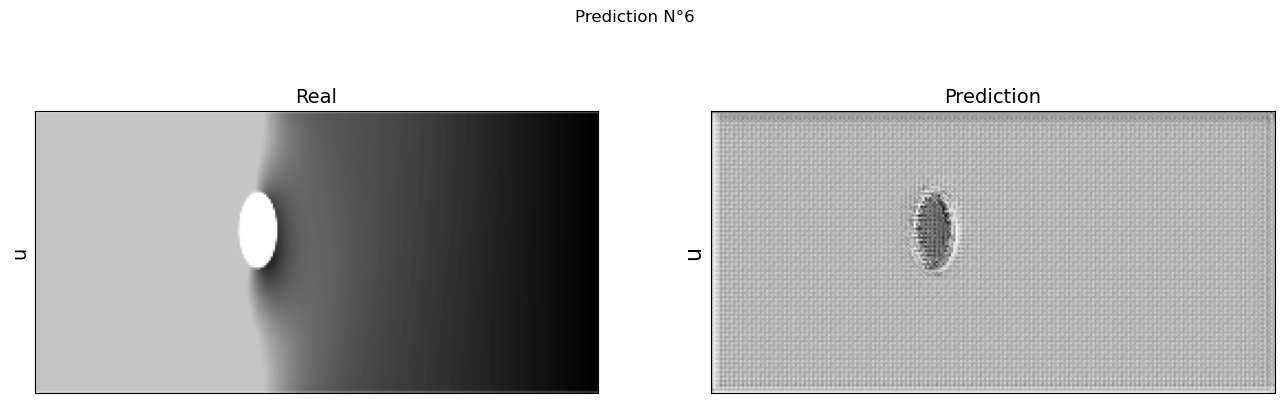

In [22]:

NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')